In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from time import time
import glob
import warnings
import os
import itertools
from glob import glob
from matplotlib.pyplot import imread

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import LearningRateScheduler
import keras.backend as K
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix,roc_curve,auc
%matplotlib inline

## Step 1: Intro
##### Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

This project attempts to identify metatastic cancer from small image patches of digital pathology scans, and the data may contain duplicate images.  The 'truth value' of a given picture having cancer is given by a 32x32 px center patch of the image containing at least one pixel of tumor tissue.   
There are 57.5k images for testing and 220k for training.  

## Step 2: EDA
##### Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

For my EDA I first checked some basic statistics about the training data such as the total number of images, the distribution of the labels for said images, and the shapes of the images.  I then visualized an example of both a positive and negative case with their associated images.  Finally I visualized the distribution of the labels for the training data.  
From both our numerical and graphical assessments we can see an imbalance between the number of images which are positive and negative.  The level of this disparity is not so high that balancing techniques were used.  Rather it was thought that if the created classifier showed a similar imbalance, we could come back and re-balance later.  This did not end up being the case here and as such it was fine to leave the slightly imbalanced dataset as it was.  
With our EDA showing us that the images are relatively clean and seem to be the same size, there isn't much more cleaning required since we were given a sanitized dataset.  All that really seems to have to happen for our analysis to continue is a normalization of our data to ensure that our classifier doesn't get confused. 
There are of course some interesting data augmentation techniques we could use as well to make the classifier more robust to changes in the images, but from the images that we've seen (only two displayed but a few looked through before clearing to clean up the notebook) the images are mostly uniform.  The actual angle of the images vary meaning rotation wouldn't matter much.  The location of the possible cancer varies by image so translation wouldn't help.  Brightness and contrast are seemingly constant but normalization helps to takes care of cases even when they may change that we haven't seen.  The only real data augmentation that we could add to add value here may be adding noise or cropping the images - barring any changes in the techniques used to image which may necessitate other data augmentation techniques in the future.  
Since the data was really just the images and their labels, it is hard to do any further EDA that would provide actual substance to the report so as such we end it there.

In [8]:
path = "../input/histopathologic-cancer-detection/" 
train_path = path + 'train'
test_path = path + 'test'

In [9]:
df = pd.read_csv(path + 'train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [10]:
df['label'] = df['label'].astype('str') #convert the label column to string so as to work w/ data generation function

def append_ext(f): #add the file extensions to the id column for data generation function
    return f+".tif"

df['id'] = df['id'].apply(append_ext)

df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [17]:
print(f"Total Number Training Images: {len(df)}")
print(f"% Positive Cases: {round((len(df[df['label'] == '1']) / len(df)) * 100,2)}%")
img_to_plot = plt.imread(train_path+'/'+df.iloc[0].id) #get the 1st entry in our train_labels dataframe
print(f"Image shapes: {img_to_plot.shape}")
img2_to_plot = plt.imread(train_path+'/'+df.iloc[1].id)

Total Number Training Images: 220025
% Positive Cases: 40.5%
Image shapes: (96, 96, 3)


This image has a label of 0 and thus contains no pixels of cancer


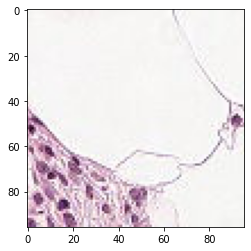

In [20]:
plt.imshow(img_to_plot)
print(f"This image has a label of {df.iloc[0].label} and thus contains no pixels of cancer")

This image has a label of 1 and thus contains at least 1 pixel of cancer.


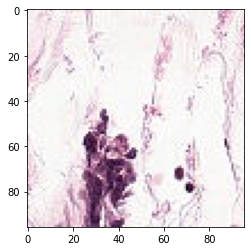

In [19]:
plt.imshow(img2_to_plot)
print(f"This image has a label of {df.iloc[1].label} and thus contains at least 1 pixel of cancer.")

<AxesSubplot:>

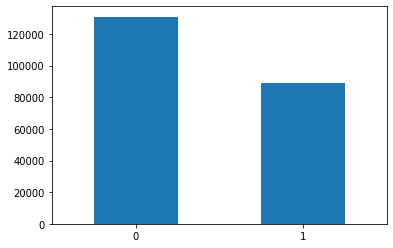

In [28]:
df.label.value_counts().plot(kind = 'bar', rot = 0)

## Data Preprocessing
Here we create train_batchs and valid_batchs which is just preparing our image data and splitting the training set 80-20 to train-validation.  The data is normalized and forced/cropped in to the given (96,96) size in case of any irregularities in the data.  
As mentioned in the EDA section the only two popular data augmentation techniques that could seemingly add value to these relatively homogonously colored but varied in size/location/rotation images would be cropping or the addition of noise.  
Since the images are, as mentioned, relatively homogonous, we can utilize the noise that is naturally generated by the differing conditions of the images.  Cropping and re-sampling individual images may add some value, but the fact that these images are taken in different spots and cut off at different edges already adds some of this and as such we continue on only doing a simple rescaling/normalization, splitting, and cropping down to the 'proper' size that we've decided on.  Additional data augmentation tasks could be useful if the imaging technology or techniques change in the future, but with the images as they are now this seems like more than enough to get a good classifier.  And in fact we find that even our incredibly simple classifiers with only these bare preprocessing steps do lead to a great classifier over a relatively tiny amount of training.

In [12]:
train_batchs = ImageDataGenerator(rescale = 1.0/255, validation_split = 0.2) \
    .flow_from_dataframe(dataframe = df, directory = train_path, target_size = (96,96), \
                         x_col = 'id', y_col = 'label', class_mode = 'binary', batch_size = 20, subset = 'training')

Found 176020 validated image filenames belonging to 2 classes.


In [13]:
valid_batchs = ImageDataGenerator(rescale = 1.0/255, validation_split = 0.2) \
    .flow_from_dataframe(dataframe = df, directory = train_path, target_size = (96,96), \
                         x_col = 'id', y_col = 'label', class_mode = 'binary', batch_size = 20, subset = 'validation')

Found 44005 validated image filenames belonging to 2 classes.


## Model Architecture
##### Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters.  

Here it was decided to compare two similar, but distinct, architectures and tune their hyperparameters.  The first architecture chosen was made to mirror the VGGNet (2014) architecture which has two convolutional layers followed by a pooling layer.  This combination was done two times before flattened and sent through our dense layers for our final output.  VGGNet is perfect for us to emulate for this task since it was originally designed for computer vision tasks and large-scale image recognition.  
Obviously this is not exactly the same as the VGGNet architecture, but it is a close facsimile thereof.  The numbers of layers was chosen to be 9 in total so as to allow for multiple runs for this mini-project within reason and also to match up with the number in our other architecture for an easier comparison.  
This second architecture simply alternated convolutional and pooling layers until ending with the same three flattening and dense layers.  This was chosen in order to compare a companion to a well-known 'good' classifier architecture to the results from a simple, no-thought approach.  It also isn't that dissimilar to the VGGNet approach and as such has the possibility of working just as well.  And as we see from the final results, it did just as well or even better!
Both of these architectures have the benefit of being simple to understand and having a relatively short training time, something perfect for our mini-project task.  The ReLU activation functions are helpful in speeding things up as well since they are more efficient as ompared to say the sigmoid functions.  A leaky ReLU may have been more applicable here but for a first pass the base ReLU seemed to work more than adequately.  

Hyperparameter tuning was done further along after the creation of each CNN where we utilized the ‘Adam’ optimizer which computes individual adaptive learning rates for each parameter.  We also ran our training through ten epochs and found the epoch in which the validation accuracy was maximized.  
There was also a bit of hyperparameter tuning in the creation of the CNNs themselves, deciding on the number of filters and such.  But this was done with a small subset of our data and was more of a cursory look than a deep tuning procedure and as such it was cut out of the notebook for space.

In [22]:
cnn1 = Sequential() #init the sequential CNN
cnn1.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96,96,3)))
cnn1.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn1.add(MaxPooling2D(pool_size = 3))

cnn1.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn1.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn1.add(MaxPooling2D(pool_size = 3))

cnn1.add(Flatten())
cnn1.add(Dense(16, activation = 'relu'))
cnn1.add(Dense(1, activation = 'sigmoid'))
cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 96, 96, 8)         224       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 96, 96, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)             

In [23]:
# optim = Adam(learning_rate = lr_schedule)
# cnn1.compile(optimizer = optim, loss = 'binary_crossentropy', metrics = ['accuracy'])
# fitting = cnn1.fit(train_batchs, epochs = 10, validation_data = valid_batchs, batch_size = train_batchs.n, verbose = 1, callbacks = early_stopping)
# #let this one play out for all 10 epochs to have a nice graph for the project.  Future ones have early stopping with patience = 1

In [24]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 2, verbose = 1, mode = 'auto') #set up early stopping procedure

In [25]:
# optim = Adam(learning_rate = 0.01, beta_1 = 0.9, beta_2 = 0.999) #Adam has it's own learning rate schedule in it, can change hparams as needed
cnn1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
fitting1 = cnn1.fit(train_batchs, epochs = 10, validation_data = valid_batchs, batch_size = train_batchs.n, verbose = 1, callbacks = early_stopping, \
                  steps_per_epoch = int(train_batchs.n / train_batchs.batch_size), validation_steps = int(valid_batchs.n / valid_batchs.batch_size))

Epoch 1/10
8801/8801 [==============================] - 744s 84ms/step - loss: 0.4130 - accuracy: 0.8139 - val_loss: 0.3420 - val_accuracy: 0.8560
Epoch 2/10
8801/8801 [==============================] - 551s 63ms/step - loss: 0.3362 - accuracy: 0.8531 - val_loss: 0.3167 - val_accuracy: 0.8629
Epoch 3/10
8801/8801 [==============================] - 559s 63ms/step - loss: 0.3135 - accuracy: 0.8648 - val_loss: 0.2991 - val_accuracy: 0.8716
Epoch 4/10
8801/8801 [==============================] - 685s 78ms/step - loss: 0.2983 - accuracy: 0.8734 - val_loss: 0.3059 - val_accuracy: 0.8674
Epoch 5/10
8801/8801 [==============================] - 1076s 122ms/step - loss: 0.2871 - accuracy: 0.8783 - val_loss: 0.2831 - val_accuracy: 0.8807
Epoch 6/10
8801/8801 [==============================] - 809s 92ms/step - loss: 0.2780 - accuracy: 0.8830 - val_loss: 0.2808 - val_accuracy: 0.8815
Epoch 7/10
8801/8801 [==============================] - 898s 102ms/step - loss: 0.2694 - accuracy: 0.8873 - val_loss

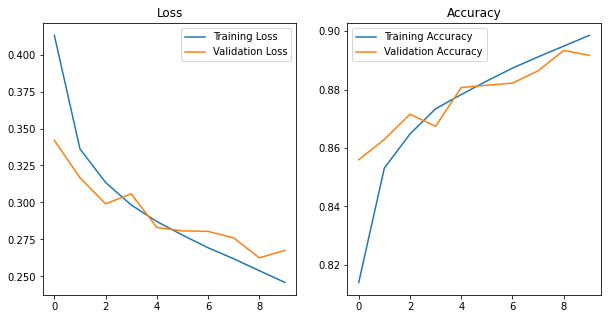

In [27]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].set_title('Loss')
axs[0].plot(fitting1.epoch, fitting1.history['loss'], label = 'Training Loss')
axs[0].plot(fitting1.epoch, fitting1.history['val_loss'], label = 'Validation Loss')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(fitting1.epoch, fitting1.history['accuracy'], label = 'Training Accuracy')
axs[1].plot(fitting1.epoch, fitting1.history['val_accuracy'], label = 'Validation Accuracy')
axs[1].legend()

The learning rate optimization is handled by our Adam optimizer which computes individual adaptive learning rates for each parameter, so we don't need to do the 'usual' learning rate optimization routines.

In [ ]:
preds = cnn1.predict_generator(valid_batchs, steps = len(valid_batchs), verbose = 1) #get predicted values
fpr, tpr, thresh = roc_curve(valid_batchs.classes, preds) #set false positive rate, true positive rate, and threshold
auc_val = auc(fpr, tpr) #get AUC value

# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr, tpr, label = f'AUC = {auc_val}')
# plt.title('ROC Curve')
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend()
# plt.show()

Now do architecture 2, compare results

In [29]:
cnn2 = Sequential() #init the sequential CNN
cnn2.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96,96,3)))
cnn2.add(MaxPooling2D(pool_size = 3))

cnn2.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn2.add(MaxPooling2D(pool_size = 3))

cnn2.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn2.add(MaxPooling2D(pool_size = 3))

cnn2.add(Flatten())
cnn2.add(Dense(16, activation = 'relu'))
cnn2.add(Dense(1, activation = 'sigmoid'))
cnn2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 96, 96, 8)         224       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 10, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 288)              

In [30]:
#do first pass to find best lr with our new architecture
cnn2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
fitting = cnn2.fit(train_batchs, epochs = 10, validation_data = valid_batchs, batch_size = train_batchs.n, verbose = 1, callbacks = early_stopping, \
                  steps_per_epoch = int(train_batchs.n / train_batchs.batch_size), validation_steps = int(valid_batchs.n / valid_batchs.batch_size))

Epoch 1/10
8801/8801 [==============================] - 460s 52ms/step - loss: 0.4300 - accuracy: 0.8047 - val_loss: 0.3572 - val_accuracy: 0.8456
Epoch 2/10
8801/8801 [==============================] - 454s 52ms/step - loss: 0.3489 - accuracy: 0.8487 - val_loss: 0.3381 - val_accuracy: 0.8544
Epoch 3/10
8801/8801 [==============================] - 450s 51ms/step - loss: 0.3231 - accuracy: 0.8627 - val_loss: 0.3099 - val_accuracy: 0.8696
Epoch 4/10
8801/8801 [==============================] - 847s 96ms/step - loss: 0.3019 - accuracy: 0.8740 - val_loss: 0.2956 - val_accuracy: 0.8794
Epoch 5/10
8801/8801 [==============================] - 925s 105ms/step - loss: 0.2882 - accuracy: 0.8796 - val_loss: 0.2767 - val_accuracy: 0.8869
Epoch 6/10
8801/8801 [==============================] - 1187s 135ms/step - loss: 0.2767 - accuracy: 0.8854 - val_loss: 0.2804 - val_accuracy: 0.8858
Epoch 7/10
8801/8801 [==============================] - 1168s 133ms/step - loss: 0.2676 - accuracy: 0.8895 - val_lo

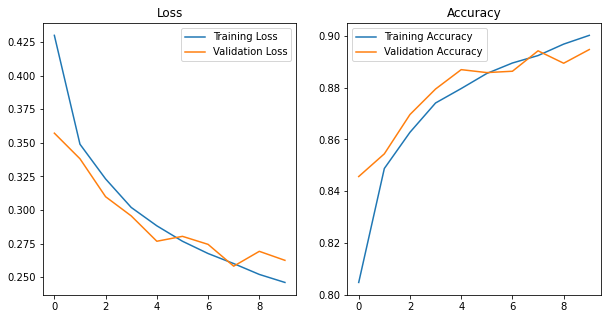

In [33]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].set_title('Loss')
axs[0].plot(fitting.epoch, fitting.history['loss'], label = 'Training Loss')
axs[0].plot(fitting.epoch, fitting.history['val_loss'], label = 'Validation Loss')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(fitting.epoch, fitting.history['accuracy'], label = 'Training Accuracy')
axs[1].plot(fitting.epoch, fitting.history['val_accuracy'], label = 'Validation Accuracy')
axs[1].legend()

Found 44005 validated image filenames belonging to 2 classes.
   1/2201 [..............................] - ETA: 3:24

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2201/2201 [==============================] - 97s 44ms/step


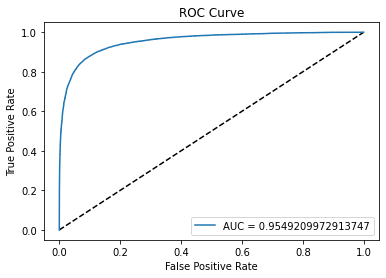

In [66]:
roc_valid_gen = ImageDataGenerator(rescale = 1.0/255, validation_split = 0.2) \
                                    .flow_from_dataframe(dataframe = df, directory = train_path, target_size = (96,96), \
                                    x_col = 'id', y_col = 'label', class_mode = 'binary', batch_size = 20, subset = 'validation', shuffle = False)

preds2 = cnn2.predict_generator(roc_valid_gen, steps = len(roc_valid_gen), verbose = 1) #get predicted values
fpr2, tpr2, thresh2 = roc_curve(valid_batchs.classes, preds2) #set false positive rate, true positive rate, and threshold
auc_val2 = auc(fpr2, tpr2) #get AUC value

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2, tpr2, label = f'AUC = {auc_val2}')
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [76]:
testdf = pd.DataFrame({'path':testfiles[index:index+20]})

In [77]:
testfiles[0]

'../input/histopathologic-cancer-detection/test/a7ea26360815d8492433b14cd8318607bcf99d9e.tif'

In [83]:
for index in range(0, 40, 20):
    testdf = pd.DataFrame({'path': testfiles[index:index + 20]})
    testdf['id'] = testdf.path.map(lambda x: x.split('/')[3].split(".")[0])
    

In [84]:
testdf.head()

,path,id
0,../input/histopathologic-cancer-detection/test...,test
1,../input/histopathologic-cancer-detection/test...,test
2,../input/histopathologic-cancer-detection/test...,test
3,../input/histopathologic-cancer-detection/test...,test
4,../input/histopathologic-cancer-detection/test...,test


In [96]:
#this way of getting the submission files for kaggle is taken from https://www.kaggle.com/code/twhitehurst3/cancer-detect-keras-92-acc

testfiles = glob(os.path.join(path + 'test/','*tif'))
submission_df = pd.DataFrame()

for index in range(0, len(testfiles), 20): 
# for index in range(0, 40, 20): #for testing
    data_frame = pd.DataFrame({'path': testfiles[index:index + 20]})
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[4].split(".")[0])
    data_frame['image'] = data_frame['path'].map(imread)
    images = np.stack(data_frame.image, axis=0)
    pred_labels = [cnn2.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
    pred_vals = np.array(pred_labels)
    data_frame['label'] = pred_vals
    submission_df = pd.concat([submission_df, data_frame[["id", "label"]]])
    if index % 1000 == 0:
        print(index/len(testfiles) * 100)

0.0
1.7404016847088306
3.480803369417661
5.221205054126492
6.961606738835322
8.702008423544154
10.442410108252984
12.182811792961816
13.923213477670645
15.663615162379477
17.404016847088307
19.14441853179714
20.884820216505968
22.6252219012148
24.365623585923633
26.10602527063246
27.84642695534129
29.586828640050122
31.327230324758954
33.067632009467786
34.808033694176615
36.54843537888544
38.28883706359428
40.02923874830311
41.769640433011936
43.51004211772077
45.2504438024296
46.99084548713843
48.731247171847265
50.471648856556094
52.21205054126492
53.95245222597376
55.69285391068258
57.43325559539142
59.173657280100244
60.91405896480908
62.65446064951791
64.39486233422674
66.13526401893557
67.8756657036444
69.61606738835323
71.35646907306207
73.09687075777089
74.83727244247973
76.57767412718856
78.31807581189739
80.05847749660622
81.79887918131504
83.53928086602387
85.2796825507327
87.02008423544154
88.76048592015037
90.5008876048592
92.24128928956803
93.98169097427686
95.7220926589

In [97]:
submission_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.415955
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.003709
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.019071
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.233396
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.136966


In [99]:
# submission_df.to_csv('submission_model.csv', index = False, header = True)

## Results and Analysis
##### Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.
##### Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

|CNN1||
|----|----|
|Epoch|Val. Acc.|
|0|0.85|
|2|0.87|
|4|0.88|
|6|0.88|
|8|0.89|
|10|0.89|


|CNN2||
|----|----|
|Epoch|Val. Acc.|
|0|0.85|
|2|0.87|
|4|0.88|
|6|0.88|
|8|0.88|
|10|0.89|

#### Note:
Max Validation Acc over all models: From CNN2 where Epoch == 7, Val. Acc. == 0.895

## Results, Analysis, and Conclusion

The actual hyperparameter tuning was done above but here the details of it will be given a quick walkthrough as well as some results.
First, as mentioned previously, our ‘Adam’ optimizer allowed us to adaptively learn learning rates for each parameter in our model thus fine-tuning our learning rate in a way that is behind the scenes but seemingly much better than a ham-fisted approach might get us in a similar amount of time.  
Second, we had a very liberal early stopping procedure in hand in case we started getting egregious losses in validation loss through our training procedure.  It didn’t end up triggering as we seem to have not hit the end of what our model can do as evidenced by our Loss Vs. Epoch and Accuracy vs. Epoch graphs.  If we look specifically at the CNN2 graphs we can see that while our losses were starting to even out, they were still at a point where appreciable gains could be made by adding on more epochs.  The same could be said for the continuing rise in our adjacent validation (and training) accuracies.  What this says is that should we redo our training with even more epochs we would continue to see gains across the board without having to change a single other hyperparameter in our model, nor the model architecture itself.  The reason that we don’t do this is that our current training takes over two hours to get through just these 10 epochs and we have already ran through them multiple times.  For a week-long mini-project we already have more than respectable results.  
Because our model worked so well on this run, there thankfully wasn’t much troubleshooting to do.  An increase in the number of epochs would be in order first before we started changing out other possible hyperparameters or even our architecture itself, just so that we could see the limit of what this current set up can do.  
Our only other real hyperparameter tuning was done in the creation of the CNNs themselves as mentioned previously.  Choosing the number of filters was done by sampling a small section of the training data, running through the modeling and comparing results and runtimes.  What was chosen was chosen due to reasonable results and smaller runtimes.  
Other than assessing the Loss and Accuracies, we also graphed the ROC curves above (one is commented out to save space, but can be re-run as needed).  From this we see that our results are, again, fantastic for what is truly a simple model.  Even with just the results from 10 epochs being run we see an AUC of around 0.955, and when we pass our results through to Kaggle we get a testing accuracy of 0.8855 (private) and 0.9081 (public).  

Overall our model performs well with minimal tuning (or rather the hardest tuning being done behind-the-scenes via our optimizer), and it isn’t even at its peak yet.  Before I change anything else within this set up I would rerun the code but with say 20 epochs and assess if the model continues to improve or if a dropoff occurs at some point.  If we were to see a dropoff before we get results that we’d find acceptable for such a long training procedure it may be possible to improve it by adding in some of the previously mentioned data augmentation techniques.  But for what it is now we have a powerful, simple, and relatively quick CNN for cancer detection.


##### Note:
The public testing accuracy from kaggle uses about 49% of the test data, the other 51% are used by the private accuracy.  Taking their average gives us our overall accuracy of our model.

In [33]:
public_acc = 0.9306
private_acc = 0.8855
mean_testing_acc = round(np.mean([public_acc, private_acc]),4)
mean_testing_acc

0.908